<a href="https://colab.research.google.com/github/mahalasanayak/PlantDisease/blob/main/html_dense121_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import cv2 as cv 
import matplotlib.pyplot as plt
import os
import pickle
from collections import defaultdict

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model
from keras.layers import *
from sklearn.model_selection import train_test_split
from keras.callbacks import *

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [5]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','rice_leafsmut','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','rice_brown_spot','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','rice_leaf_blight','Tomato_healthy']
data_dir = '/content/drive/MyDrive/archive/PlantVillage'
train_dir = os.path.join(data_dir)

In [6]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
18473,Tomato_healthy/59e72cea-137e-4c76-ba58-8b60aab...,14,Tomato_healthy
18474,Tomato_healthy/583238e5-392b-40ef-9bbe-be54bda...,14,Tomato_healthy
18475,Tomato_healthy/5b2457f5-96d5-4bcd-8025-dc55e66...,14,Tomato_healthy
18476,Tomato_healthy/5dbc2db5-5bb2-4a3c-9a90-d2228c1...,14,Tomato_healthy
18477,Tomato_healthy/5d11d60f-fb4a-4178-9594-d017a0f...,14,Tomato_healthy


In [7]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato__Target_Spot/74aecabd-84ee-44f2-8a1f-69...,11,Tomato__Target_Spot
1,Tomato__Target_Spot/95557bdf-e933-4181-a2b2-5f...,11,Tomato__Target_Spot
2,Tomato_Septoria_leaf_spot/1c721799-1ac2-47dd-8...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/d4091850-464c-4655-9edc-395f43c...,14,Tomato_healthy
4,Pepper__bell___healthy/ab4b562f-c5f1-4c24-826e...,1,Pepper__bell___healthy


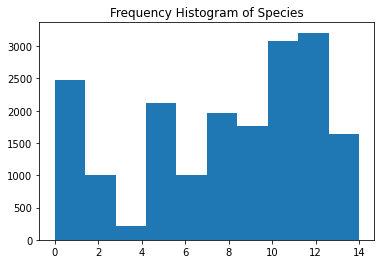

<Figure size 864x864 with 0 Axes>

In [8]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [9]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [10]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

109it [01:04,  1.57it/s]

KeyboardInterrupt: ignored

In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [ ]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

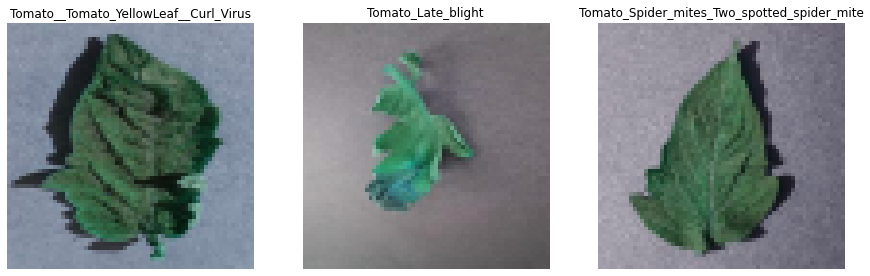

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 40
SIZE=64
N_ch=3

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2624

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
230/230 - 1091s - loss: 2.5343 - accuracy: 0.3400 - val_loss: 1.5004 - val_accuracy: 0.5557

Epoch 00001: val_loss improved from inf to 1.50044, saving model to model.h5
Epoch 2/40
230/230 - 1019s - loss: 1.0937 - accuracy: 0.6614 - val_loss: 1.7175 - val_accuracy: 0.6253

Epoch 00002: val_loss did not improve from 1.50044
Epoch 3/40
230/230 - 1018s - loss: 0.7188 - accuracy: 0.7640 - val_loss: 1.0981 - val_accuracy: 0.6889

Epoch 00003: val_loss improved from 1.50044 to 1.09813, saving model to model.h5
Epoch 4/40
230/230 - 1030s - loss: 0.5376 - accuracy: 0.8242 - val_loss: 1.7416 - val_accuracy: 0.6661

Epoch 00004: val_loss did not improve from 1.09813
Epoch 5/40
230/230 - 1032s - loss: 0.4173 - accuracy: 0.8650 - val_loss: 1.0944 - val_accuracy: 0.7311

Epoch 00005: val_loss improved from 1.09813 to 1.09440, saving model to model.h5
Epoch 6/40
230/230 - 1037s - loss: 0.3131 - accuracy: 0.8977 - val_loss: 0.9380 - val_accuracy: 0.7849

Epoch 00006: val_loss improved from

In [ ]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

116/116 [==============================] - 2s 18ms/step - loss: 0.0887 - accuracy: 0.9738
Final Loss: 0.08870946615934372, Final Accuracy: 0.973755419254303


Text(0.5, 144.41374999999996, 'Predicted')

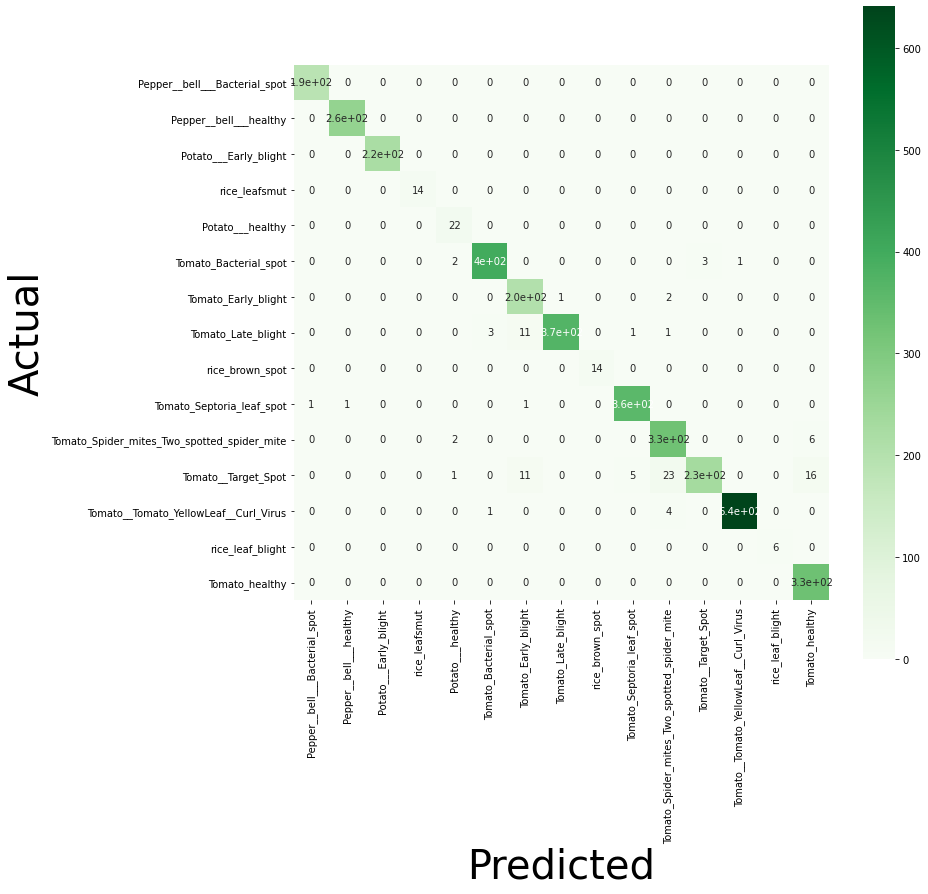

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

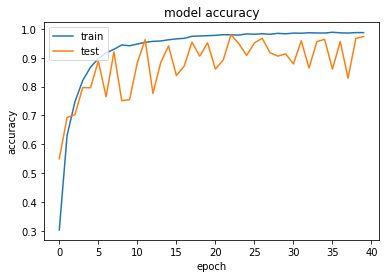

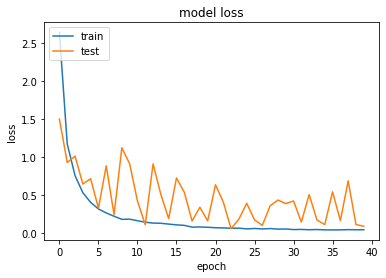

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!pip install flask_ngrok

In [ ]:
from flask import *
from flask_ngrok import run_with_ngrok
from skimage import io
from keras.preprocessing import image

In [ ]:
app=Flask(__name__)

In [ ]:
def classify_image(filename):
  img = image.load_img(filename, grayscale=False, target_size=(64, 64))
  print(filename)
  show_img=image.load_img(filename, grayscale=False, target_size=(200, 200))
  disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','rice_leafsmut','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','rice_brown_spot','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','rice_leaf_blight','Tomato_healthy']
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  #x = np.array(x, 'float32')
  x /= 255

  custom = model.predict(x)
  print(custom[0])



    #x = x.reshape([64, 64]);

    #plt.gray()
  plt.imshow(show_img)
  plt.show()

  a=custom[0]
  ind=np.argmax(a)
        
  print('Prediction:',disease_class[ind])
  return('Prediction:',disease_class[ind])






In [ ]:
@app.route('/')
def home():
  return render_template('index.html')


@app.route('/result.html',methods=['POST','GET'])
def classify():
  if request.method =='POST':
    filen=request.files['img']
    filen.save(os.path.join("static",filen.filename))
    result1, result2 =classify_image(os.path.join("static",filen.filename))
    return render_template('result.html',name1=result1,name2=result2, name3=filen.filename)


In [ ]:
run_with_ngrok(app)
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c200862dd7b2.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [09/Jul/2021 07:36:05] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2021 07:36:06] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [09/Jul/2021 07:36:06] "GET /static/leaves.jpg HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2021 07:36:07] "GET /static/css/icon.png HTTP/1.1" 404 -
127.0.0.1 - - [09/Jul/2021 07:36:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Jul/2021 07:36:09] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [09/Jul/2021 07:36:09] "GET /static/leaves.jpg HTTP/1.1" 200 -
[2021-07-09 07:36:19,242] ERROR in app: Exception on /result.html [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc